Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 2

=== Phân tích mạng ===
Số node: 77
Số cạnh: 254
Clustering trung bình: 0.573


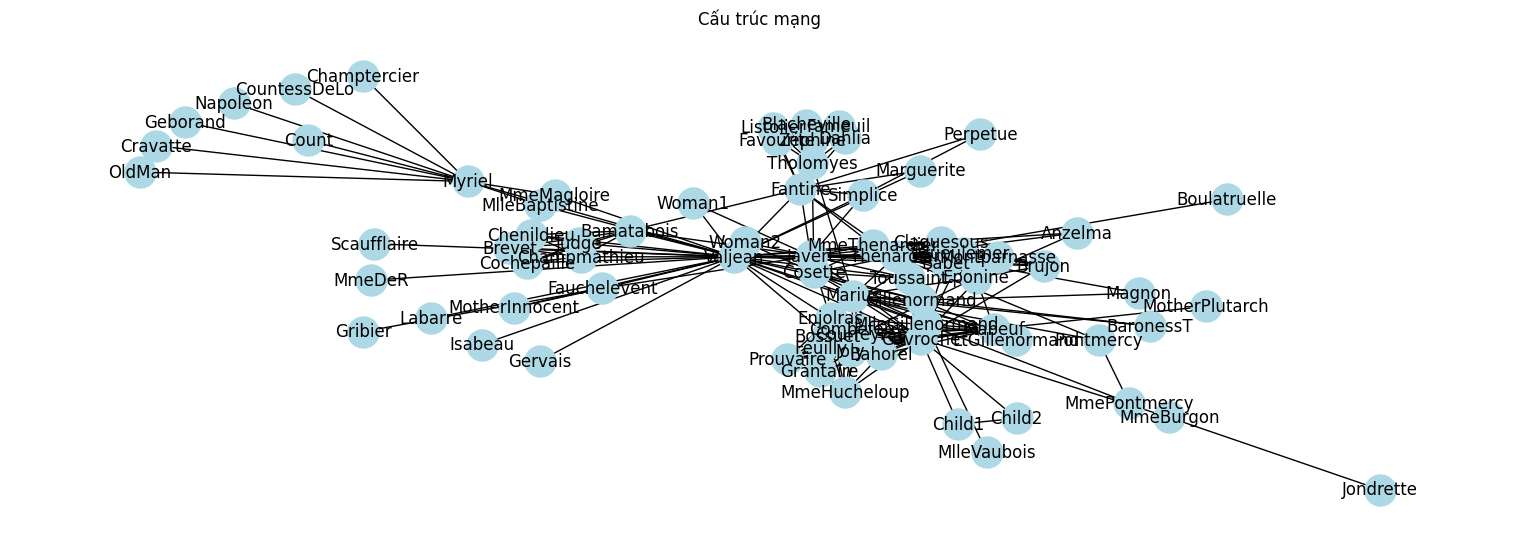

Train edges: 204
Test positive edges: 50
Test negative edges: 50

Bảng so sánh kết quả cho các phương pháp:
                    Method     AUC  Accuracy  Precision  Recall  F1-score
0         Common Neighbors  0.9336      0.80   0.734375    0.94  0.824561
1      Jaccard Coefficient  0.8958      0.80   0.734375    0.94  0.824561
2              Adamic-Adar  0.9416      0.80   0.734375    0.94  0.824561
3  Preferential Attachment  0.8100      0.48   0.489583    0.94  0.643836


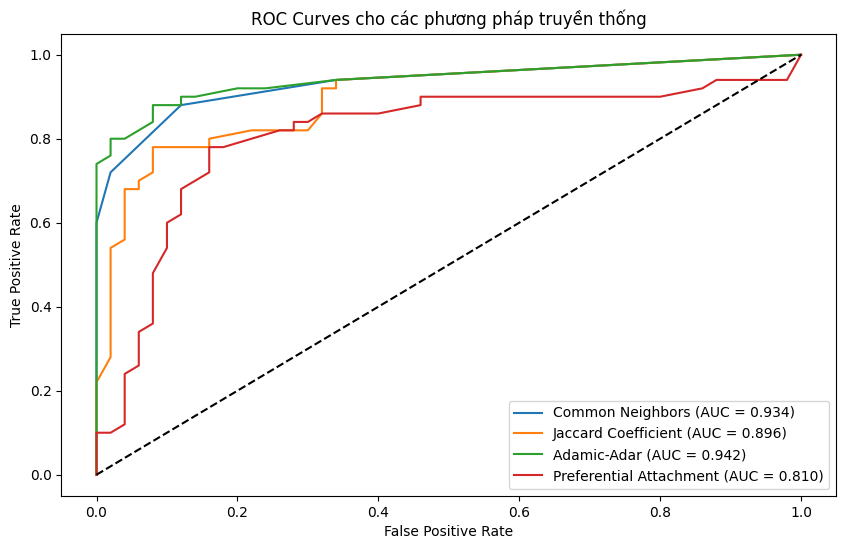


Kết quả AUC cho các phương pháp:
Common Neighbors: 0.934
Jaccard Coefficient: 0.896
Adamic-Adar: 0.942
Preferential Attachment: 0.810

Bảng kết quả mở rộng với Random Forest:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.933600  0.800000   0.734375  0.940000  0.824561
1      Jaccard Coefficient  0.895800  0.800000   0.734375  0.940000  0.824561
2              Adamic-Adar  0.941600  0.800000   0.734375  0.940000  0.824561
3  Preferential Attachment  0.810000  0.480000   0.489583  0.940000  0.643836
4            Random Forest  0.986425  0.933333   1.000000  0.882353  0.937500


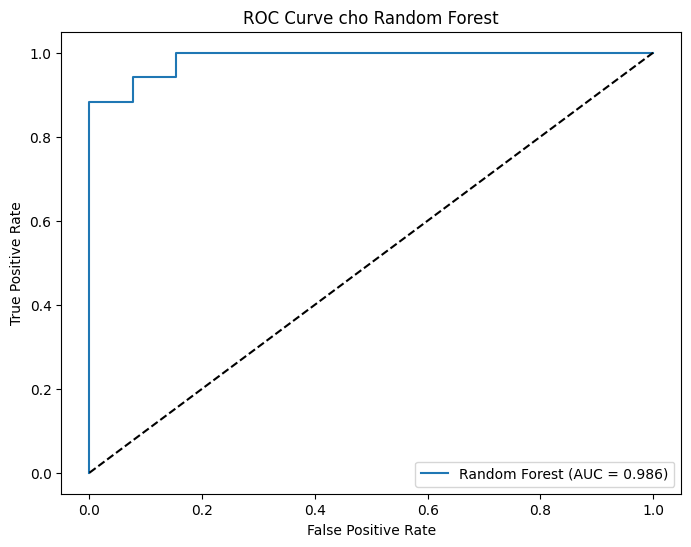

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)

        # Vẽ ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve cho Random Forest')
        plt.legend()
        plt.show()


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]  # Dự đoán nhị phân

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ ROC Curves
        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_scores):.3f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống')
        plt.legend()
        plt.show()

        print("\nKết quả AUC cho các phương pháp:")
        # Sử dụng results_df thay vì results để in kết quả AUC
        for _, row in self.results_df.iterrows():
            print(f"{row['Method']}: {row['AUC']:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")



1. So sánh kết quả các phương pháp truyền thống với bộ dữ liệu Florentine Families Network:
- Các phương pháp Common Neighbors, Jaccard Coefficient, và Adamic-Adar có AUC rất thấp (0.25), giá trị này rất thấp, nằm dưới mức ngẫu nhiên (0.5).
Điều này chứng tỏ các phương pháp này không có khả năng phân biệt các liên kết với bộ dữ liệu này. Hiệu suất gần như là phân loại sai hoàn toàn hoặc chỉ ra các liên kết không chính xác.
- Phương pháp Preferential Attachment có AUC giá trị này còn thấp hơn(0.15625), thể hiện mô hình hoàn toàn thất bại trong việc dự đoán các liên kết. Có thể đây là do mô hình có sự thiên lệch hoặc dữ liệu không phù hợp với phương pháp này.
- Precision và Recall của 3 phương pháp đầu là 0.00, chỉ riêng Preferential Attachment có giá trị 0.25.

2. Kết quả với random forest:
- vượt trội hơn hẳn so với các phương pháp truyền thống, thể hiện khả năng học mạnh mẽ và chính xác. Điều này chứng minh rằng mô hình học máy như Random Forest có thể khai thác tốt hơn các đặc trưng để dự đoán liên kết trong đồ thị với bộ dataset này.
